# TP 2-3 : Branch-and-bound applied to a knapsack problem

### Initialisation (à faire une seule fois)

In [1]:
import Pkg; 
Pkg.add("GraphRecipes"); Pkg.add("Plots"); 
using GraphRecipes, Plots #only used to visualize the search tree at the end of the branch-and-bound

   Updating registry at `~/.julia/registries/General`
  Resolving package versions...
  Installed Netpbm ───────────── v1.1.0
  Installed GraphRecipes ─────── v0.5.5
  Installed ImageAxes ────────── v0.6.10
  Installed GraphPlot ────────── v0.5.2
  Installed StatsBase ────────── v0.33.21
  Installed IJulia ───────────── v1.23.3
  Installed Compose ──────────── v0.9.4
  Installed ImageMetadata ────── v0.9.8
  Installed ImageBase ────────── v0.1.5
  Installed GeometryBasics ───── v0.3.10
  Installed ImageCore ────────── v0.9.4
  Installed NetworkLayout ────── v0.2.0
  Installed ColorSchemes ─────── v3.20.0
  Installed TranscodingStreams ─ v0.9.10
  Installed MozillaCACerts_jll ─ v2022.10.11+0
  Installed StructArrays ─────── v0.4.2
  Installed Parsers ──────────── v2.4.2
  Installed Interpolations ───── v0.12.10
######################################################################### 100,0%
   Updating `~/.julia/environments/v1.4/Project.toml`
  [13f3f980] ↓ CairoMakie v0.7.2 ⇒ v0.6.4
 

### Récupération des données

In [2]:
function readKnaptxtInstance(filename)
    price=[]
    weight=[]
    KnapCap=[]
    open(filename) do f
        for i in 1:3
            tok = split(readline(f))
            if(tok[1] == "ListPrices=")
                for i in 2:(length(tok)-1)
                    push!(price,parse(Int64, tok[i]))
                end
            elseif(tok[1] == "ListWeights=")
                for i in 2:(length(tok)-1)
                    push!(weight,parse(Int64, tok[i]))
                end
            elseif(tok[1] == "Capacity=")
                push!(KnapCap, parse(Int64, tok[2]))
            else
                println("Unknown read :", tok)
            end 
        end
    end
    capacity=KnapCap[1]
    return price, weight, capacity
end

readKnaptxtInstance (generic function with 1 method)

### Tests de sondabilités TA, TO et TR basés sur le modèle linéaire

In [3]:
function TestsSondabilite_LP(model2, x, BestProfit, Bestsol)
    TA, TO, TR = false, false, false
    if(termination_status(model2) == MOI.INFEASIBLE)#Test de faisabilite
        TA=true
        println("TA")
    elseif(objective_value(model2) <= BestProfit) #Test d'optimalite
        TO=true
        println("TO")
    elseif( prod(abs.([round.(v, digits=0) for v in value.(x)]-value.(x)) .<= fill(10^-5, size(x))) 
        ) #Test de resolution
        TR=true
        println("TR")
        #if (value(benef) >= BestProfit)
        if (objective_value(model2) >= BestProfit)
            Bestsol = value.(x)
            #BestProfit=value(benef)
            BestProfit=objective_value(model2)
            println("\nNew Solution memorized ", Bestsol, " with bestprofit ", BestProfit, "\n")
        end
    else
        println("non sondable")
    end
    TA, TO, TR, Bestsol, BestProfit
end

TestsSondabilite_LP (generic function with 1 method)

## Procédure de séparation (branching) et stratégie d'exploration permettant de se placer au prochain noeud à traiter

In [4]:

function SeparerNoeud_lexicographic_depthfirst!(listobjs, listvals, n)
    # this node is non-sondable. Apply the branching criterion to separate it into two subnodes
    # and choose the child-node at the left  
    
    # lexicographic branching criterion: branch on the 1st object not yet fixed
    i, obj = 1, 0
    while((i <= n) && (obj==0))
        if(!(i in listobjs))
            obj=i
        end
        i+=1
    end
    
    println("\nbranch on object ", obj, "\n")

    # depthfirst exploration strategy: the node selected will be the most left of the child-nodes just created
    push!(listobjs,obj) #save the identity of the object selected for branching
    push!(listvals,1.0) #save the node selected, identified by the value assigned to the variable/object chosen
end


function ExplorerAutreNoeud_depthfirst!(listobjs, listvals, listnodes)
    #this node is sondable, go back to parent node then right child if possible
    
    stop=false
    #check if we are not at the root node
    if (length(listobjs)>= 1)
        #go back to parent node
        obj=pop!(listobjs)
        theval=pop!(listvals)
        tmp=pop!(listnodes)

        #go to right child if possible, otherwise go back to parent
        while( (theval==0.0) && (length(listobjs)>= 1))
            obj=pop!(listobjs)
            theval=pop!(listvals)
            tmp=pop!(listnodes)
        end
        if theval==1.0
            push!(listobjs,obj)
            push!(listvals,0.0)
        else
            println("\nFINISHED")
            stop=true
        end
    else
        #the root node was sondable
        println("\nFINISHED")
        stop=true
    end
    return stop 
end

ExplorerAutreNoeud_depthfirst! (generic function with 1 method)

###  Création de la relaxation linéaire (= modèle associé au noeud 0): <span style="color:red"> SECTION A SUPPRIMER !!!! </span>

<span style="color:red"> Cette section est à commenter/supprimer et remplacer par vos propres calculs de bornes supérieures et autres, par exemple basées sur les bornes 1 et 2 vues en cours, ou d'autres calculs de bornes de votre choix/conception validés au préalable par votre encadrant/e de TP </span>

In [5]:
Pkg.add("Clp");
Pkg.add("JuMP");
using JuMP, Clp

function MajModele_LP!(model2, x, listobjs, listvals)
    for i in 1:length(listobjs)
        set_lower_bound(x[listobjs[i]],listvals[i])
        set_upper_bound(x[listobjs[i]],listvals[i])
    end
end

function Reset_LP!(model2, x, listobjs)
    for i in 1:length(listobjs)
        set_lower_bound(x[listobjs[i]],0.0)
        set_upper_bound(x[listobjs[i]],1.0)
    end
end

function Reset_allLP!(model2, x)
    for i in 1:length(x)
        set_lower_bound(x[i],0.0)
        set_upper_bound(x[i],1.0)
    end
end

function CreationModele_LP(price, weight, capacity)
# ROOT NODE
    
    n=length(price)
    
    model2 = Model(Clp.Optimizer) # set optimizer
    set_optimizer_attribute(model2, "LogLevel", 0) #don't display anything during solve
    set_optimizer_attribute(model2, "Algorithm", 4) #LP solver chosen is simplex

    # define x variables as CONTINUOUS (recall that it is not possible to define binary variables in Clp)
    @variable(model2, 0 <= x[i in 1:n] <= 1)

    # define objective function
    @objective(model2, Max, sum(price[i]*x[i] for i in 1:n))

    # define the capacity constraint 
    @constraint(model2, sum(weight[i]*x[i] for i in 1:n) <=  capacity)

    println(model2) 

    return model2, x
end

  Resolving package versions...
  Installed MUMPS_seq_jll ──── v5.4.0+0
  Installed Clp ────────────── v0.9.1
  Installed BenchmarkTools ─── v1.3.2
  Installed MathOptInterface ─ v0.10.9
######################################################################### 100,0%
   Updating `~/.julia/environments/v1.4/Project.toml`
  [e2554f3b] + Clp v0.9.1
   Updating `~/.julia/environments/v1.4/Manifest.toml`
  [6e4b80f9] + BenchmarkTools v1.3.2
  [b99e7846] + BinaryProvider v0.5.10
  [e2554f3b] + Clp v0.9.1
  [06985876] + Clp_jll v100.1700.600+0
  [523fee87] + CodecBzip2 v0.7.2
  [be027038] + CoinUtils_jll v2.11.4+2
  [d00139f3] + METIS_jll v5.1.0+5
  [d7ed1dd3] + MUMPS_seq_jll v5.4.0+0
  [b8f27783] + MathOptInterface v0.10.9
  [d8a4904e] + MutableArithmetics v0.3.3
  [656ef2d0] + OpenBLAS32_jll v0.3.9+4
  [7da25872] + Osi_jll v0.108.6+2
   Building Clp → `~/.julia/packages/Clp/INUeN/deps/build.log`
  Resolving package versions...
  Installed ForwardDiff ─ v0.10.32
  Installed JuMP ──────── v0.

CreationModele_LP (generic function with 1 method)

### Boucle principale : résoudre une relaxation, appliquer les tests de sondabilité, identifier le prochain noeud, répéter.

In [6]:

function SolveKnapInstance(filename)

    price, weight, capacity = readKnaptxtInstance(filename)

    model2, x = CreationModele_LP(price, weight, capacity)

    #create the structure to memorize the search tree for visualization at the end
    trParentnodes=Int64[] #will store orig node of arc in search tree
    trChildnodes=Int64[] #will store destination node of arc in search tree
    trNamenodes=[] #will store names of nodes in search tree

    #intermediate structure to navigate in the search tree
    listobjs=[]
    listvals=[]
    listnodes=[]

    BestProfit=-1
    Bestsol=[]

    current_node_number=0
    stop = false

    while(!stop)

        println("\nNode number ", current_node_number, ": \n---------------\n")

        #Update the graphical tree
        push!(trNamenodes,current_node_number+1) 
        if(length(trNamenodes)>=2)
            push!(trParentnodes,listnodes[end]+1) # +1 because the 1st node is "node 0"
            push!(trChildnodes, current_node_number+1) # +1 because the 1st node is "node 0"
        end
        push!(listnodes, current_node_number)

        
        #create LP of current node
        MajModele_LP!(model2, x, listobjs, listvals)
        
        println(model2)
        
        print("Solve the LP model of the current node to compute its bound: start ... ")

        status = optimize!(model2)

        println("... end"); 

        print(": Solution LP")
        if(termination_status(model2) == MOI.INFEASIBLE)#(has_values(model2))
            print(" : NOT AVAILABLE (probably infeasible or ressources limit reached)")
        else
            print(" ", objective_value(model2))
            [print("\t", name(v),"=",value(v)) for v in all_variables(model2)] 
        end
        println(" "); 


        println("\nPrevious Solution memorized ", Bestsol, " with bestprofit ", BestProfit, "\n")

        TA, TO, TR, Bestsol, BestProfit = TestsSondabilite_LP(model2, x, BestProfit, Bestsol)

        is_node_sondable = TA || TO || TR

        #Reset_LP!(model2, x, listobjs)

        if(!is_node_sondable)
            SeparerNoeud_lexicographic_depthfirst!(listobjs, listvals, length(price))
        else
            stop = ExplorerAutreNoeud_depthfirst!(listobjs, listvals, listnodes)
        end
        
        Reset_allLP!(model2, x)

        current_node_number = current_node_number + 1
    end

    println("\n******\n\nOptimal value = ", BestProfit, "\n\nOptimal x=", Bestsol)

    return BestProfit, Bestsol, trParentnodes, trChildnodes, trNamenodes

end


SolveKnapInstance (generic function with 1 method)

### Affichage du résultat final

Max 42 x[1] + 40 x[2] + 12 x[3] + 25 x[4]
Subject to
 7 x[1] + 4 x[2] + 3 x[3] + 5 x[4] ≤ 10.0
 x[1] ≥ 0.0
 x[2] ≥ 0.0
 x[3] ≥ 0.0
 x[4] ≥ 0.0
 x[1] ≤ 1.0
 x[2] ≤ 1.0
 x[3] ≤ 1.0
 x[4] ≤ 1.0


Node number 0: 
---------------

Max 42 x[1] + 40 x[2] + 12 x[3] + 25 x[4]
Subject to
 7 x[1] + 4 x[2] + 3 x[3] + 5 x[4] ≤ 10.0
 x[1] ≥ 0.0
 x[2] ≥ 0.0
 x[3] ≥ 0.0
 x[4] ≥ 0.0
 x[1] ≤ 1.0
 x[2] ≤ 1.0
 x[3] ≤ 1.0
 x[4] ≤ 1.0

Solve the LP model of the current node to compute its bound: start ... ... end
: Solution LP 76.0	x[1]=0.857142857142857	x[2]=1.0	x[3]=0.0	x[4]=0.0 

Previous Solution memorized Any[] with bestprofit -1

non sondable

branch on object 1


Node number 1: 
---------------

Max 42 x[1] + 40 x[2] + 12 x[3] + 25 x[4]
Subject to
 7 x[1] + 4 x[2] + 3 x[3] + 5 x[4] ≤ 10.0
 x[1] ≥ 1.0
 x[2] ≥ 0.0
 x[3] ≥ 0.0
 x[4] ≥ 0.0
 x[1] ≤ 1.0
 x[2] ≤ 1.0
 x[3] ≤ 1.0
 x[4] ≤ 1.0

Solve the LP model of the current node to compute its bound: start ... ... end
: Solution LP 72.0	x[1]=1.0	x[2]=0.7500

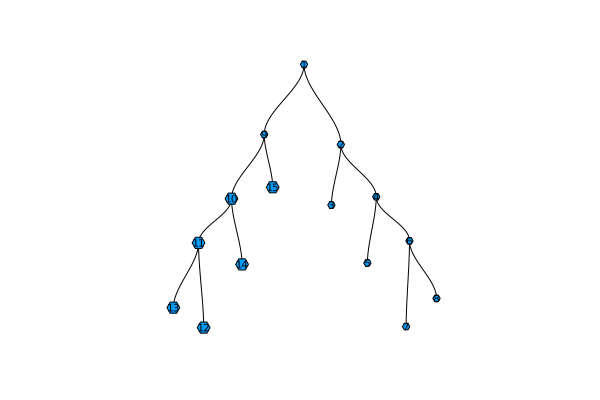

In [7]:
BestProfit, Bestsol, trParentnodes, trChildnodes, trNamenodes = SolveKnapInstance("instancesETU/KNAPnewformat/test.opb.txt")
println("\n******\n\nOptimal value = ", BestProfit, "\n\nOptimal x=", Bestsol)
graphplot(trParentnodes, trChildnodes, names=trNamenodes, method=:tree)